# Statistics

For each group of participants and for all trajectories we study the following statistics:

    1. Total amount of time spent (T)
\begin{align}
T=\sum_{t=0}^{N-1} \Delta (t)
\end{align}
with $\Delta (t)$ the time difference between consecutive GPS records (time stamps). Which is irregular in our data

    2. Total distance travelled (D) and Euclidean distances (d) between geo-locations.
\begin{align}
d(t)=\vert \vec{r}(t+\Delta (t)) - \vec{r}(t) \vert
\end{align}

\begin{align}
D=\sum_{t=0}^{N-1} d(t)
\end{align}


    3. Instantaneous velocity (v):
\begin{align}
v(t)=\frac{\vert \vec{r}(t+\Delta (t)) - \vec{r}(t) \vert}{\Delta (t)} = \frac{d(t)}{\Delta (t)}
\end{align}

    4. Radius of gyration (Rg):
\begin{align}
R_{g}=\sqrt{\frac{1}{N}\sum_{t=1}^{N}\left( \vec{r}(t)-\vec{r}(0) \right)^{2}}
\end{align}  

where $\vec{r}(t)$ are the coordinates of the N individual points, being  $\vec{r}(0)$ the position of the center of mass of the set of points, $r_{cm}=\sum_{t=1}^{N} \vec{r}(t)/N$. In human mobility, it characterizes the typical distance of an individual from the center of mass of their trajectory.

    5. Turtuosity:
\begin{align}
T=1- \langle cos(\theta (t)) \rangle
\end{align}    

where $\theta (t)$ is the angle between the current position at the time stamp "t" and the last position "N". It gives a measure of how inefficient the path is with respect to the final destination. That is, how turbulent and dispersed it is.
    
    6. Stops duration 
    
We consider the position at the time stamp "t" as stopped if $\Delta (t) \geq 10s$. Then, the value of $\Delta (t)$ is the duration of the stop. If we detect two or more consecutive stops, we consider a single stop with the duration corresponding to the sum of all of them. 

    7. Orientation respect to the North
We also compute the angle (orientation) between each vector (two consecutive GPS records which form a vector in the direction of the movement). We plot the polar histograms.

    8. Re-orientation (turning angle)
Finally, we also compute the change in the orientation between two consecutive orientations (therefore, the "turning" angle). We also plot the pdf of reorientation angles.


#### Import libraries

In [1]:
from gpxcsv import gpxtolist
import pandas as pd
import networkx as nx
import osmnx as ox


import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from math import sin, cos, sqrt, atan2, radians
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from folium import Map
from folium.plugins import HeatMap, HeatMapWithTime
import utm
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from scipy.stats import gaussian_kde
from shapely.geometry import Point, LineString, Polygon
import folium

#%matplotlib notebook
#%matplotlib inline
ox.config(use_cache=True, log_console=True)
ox.__version__





C:\Users\josep\anaconda3\envs\ox\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


'1.3.0'

#### Functions

In [3]:
def GPScoordinates_to_utm(lat,lon):
    """" Function that projects the GPS coordinates in degrees (latitude, longitude) into the UTM coordinate system
    in order to work with the concept of "point" and "Euclidean distance" in a plane.
    (https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system)
    
    Note: We are dealing with locations in the same area/region. Otherwise, we should be careful if two locations 
    belong to different UTM zones when calculating distances, etc. 
    
    Input:
        - lists of GPS coordinates: latitude and longitude
        
    Output:
        - lists of the UTM projections of the GPS coordinates: 
        - The utm package returns Easting, Northing, Zone_number and Zone_letter. So we only store the two first elements
    """
    
    lat_utm=[]
    lon_utm=[]
    for i in range(len(lat)):
        u=utm.from_latlon(lat[i],lon[i])  # get the UTM projection
        lat_utm.append(u[0])   # Store the projection of latitude and longitude in lists
        lon_utm.append(u[1])
        
    return lat_utm, lon_utm
        
    

def EuclidianDistance(x1,y1,x2,y2):
    """ Function that returns the distance in metres between 2 points in a p(NO GPS locs.) 
    
    Note: Be careful as the GPS coordinates (lat,lon) cannot be used, but their projections to a plane (e.g. utm projection).

    
    Input:
        - The coordinates of two points in a plane: (x1,y1) and (x2,y2).
        
    Output:
        - Euclidian distance in metres between the two points.
    """
    Euclidian_distance = ( (x2-x1)**2 + (y2-y1)**2 ) ** 0.5
        
    return Euclidian_distance
        
    
        
def getDistanceFromLatLonInM(lat1,lon1,lat2,lon2):
    """ Function that returns the distance in metres between 2 GPS locations in degrees (latitude and longitude).
    It is based in the Haversine formula (https://en.wikipedia.org/wiki/Haversine_formula) which takes into account the
    Earth's curvature. 
    
    Input:
        - 2 GPS coordinates: (latitude1,longitude1) of the first point and (latitude2,longitude2) of the second point. 
        
    Output:
        - Distance in metres between the two GPS locations.
    """
    
    R = 6371 # Radius of the earth in km
    dLat = radians(lat2-lat1)  # Diference between latitudes in radians
    dLon = radians(lon2-lon1) # Diference between longitudes in radians
    rLat1 = radians(lat1)   # Latitudes in radians
    rLat2 = radians(lat2)
    a = sin(dLat/2) * sin(dLat/2) + cos(rLat1) * cos(rLat2) * sin(dLon/2) * sin(dLon/2) 
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c # Distance in km
    e= d*1000 # Distance in m
   
    return e
   
    
    
def instantaneous_velocity(distance,time):
    """" Function that computes the instantenous velocity between two points, given their distance and their time difference.
    
    Input:
        - Distance between two points or two locations
        - Time difference between the two points/locations
        
    Output:
        - Instantenous velocity between the two points
    """
    
    v=distance/time
    
    return v


def convert(seconds):
    """" Function that converts the seconds to hours, minuts and seconds
    
    Input:
        - Number of seconds
        
    Output:
        - Hours, minuts and seconds
    """
    
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    
    return hour, minutes, seconds


def map_network(latitude, longitude, dist):
    """" Function that creates a map of the urban network in a given radius around a gps location.
    
    Input:
        - latitude and longitude (GPS coordinates)
        - dist: distance (radius) from which the network is constructed
        
    Output:
        - The figure and the axes.
        
    """
    
    G = ox.graph_from_point((latitude, longitude), dist, network_type='all')   # Create the graph from lat and lon
    fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor="#333333",edge_color="w", edge_linewidth=0.8, node_size=0)
    
    #for _, edge in ox.graph_to_gdfs(G, nodes=False).fillna('').iterrows():     # Name of the street
        #c = edge['geometry'].centroid
        #text = edge['name']
        #ax.annotate(text, (c.x, c.y), c='w')       
 
    return fig, ax


def map_network2(lat1,lon1,lat2,lon2,lat3,lon3,lat4,lon4):
    """" Function that creates a map of the urban network from a polygon (given the 4 bounds).
    
    Input:
        - bounds: 4 latitude and longitude points (GPS coordinates)
        
    Output:
        - The figure and the axes.
        
    """
    
    P = Polygon([(lat1,lon1), (lat2,lon2),(lat3,lon3),(lat4,lon4)])  # Create the graph from lat and lon bounds
    G = ox.graph_from_polygon(P, network_type='all') 
    fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor="#333333",edge_color="w", edge_linewidth=0.8, node_size=0)
    place_name = "Granollers, Vallès Oriental"
    tags={"building": True}
    gdf = ox.geometries_from_place(place_name, tags)
    gdf.shape
    gdf.plot(ax=ax,color='silver',alpha=0.5)
    buildings = ox.geometries_from_place(place_name, tags={'building':True}) # Retrieve buildings from the area:
    
    #for _, edge in ox.graph_to_gdfs(G, nodes=False).fillna('').iterrows():     # Name of the street
        #c = edge['geometry'].centroid
        #text = edge['name']
        #ax.annotate(text, (c.x, c.y), c='w')       
 
    return fig, ax


def RadiusOfGyration(x,y):
    """" Function that computes the radius of gyration of a 2-d trajectory with x and y coordinates.
    
    M. C. Gonzalez, C. a C. A. Hidalgo, A. L. A.-L. Barabási, M. C. González, C. A. H. 
    & A.-L. B. Marta C. González, and M. C. Gonz, Nature 453, 779 (2008).
    
    Note: x,y coordinates can't be lat,lon in degrees. Before we must project them into a plane (e.g UTM projection)
    
    
    Input:
        - Lists of coordinates x and y
    
    Output:
        - Radius of gyration
    """
    
    r_cm_x=sum(x)/len(x)
    r_cm_y=sum(y)/len(y)
    
    radius2=[]
    for i in range(len(x)):
        r_new_x=x[i]-r_cm_x
        r_new_y=y[i]-r_cm_y
        radius2.append((r_new_x*r_new_x) + (r_new_y*r_new_y))
    
    mean_radius2=sum(radius2)/len(radius2)
    
    rg=mean_radius2**0.5
    
    return rg
            

def vector(latitude0,longitude0,latitude1,longitude1): 
    """ Given two points returns the vector from the origin point to destination. If GPS coordinates, use UTM projection.
    
    Input:
        - Coordinates of origin point (p0x,p0y) and destionation point (p1x, p1y).
    
    Oputput:
        - Coordinates of the vector from p0 to p1. 
    """
    
    p0=(latitude0,longitude0)   
    p1=(latitude1,longitude1)
    vec=(p1[0]-p0[0], p1[1]-p0[1]) 
    return vec


def determinant(vec0,vec1):
    """  Returns determinant of two vectors. If det<0 means that the second vector has turned in the clockwise direction.
    
    Input:
        - Two consecutive vectors (vec0, vec1) characterized with their x,y coordinates.
        
    Output:
        - Determinant of two vectors. If det<0 the second vector has turned in the clockwise direction respect to the first.
    """
    det=vec0[0]*vec1[1]-vec0[1]*vec1[0]
    return det


def reorientation(vec0,vec1):
    """Returns the angle between two consecutive vectors (change in orientation, reorientation, turning angle)
    The range is from -pi to +pi. If det<0 the second vector has turned in the clockwise direction and therefore the 
    reorientation angle is also <0. On contrary, if has turned counter-clockwise is >0. 
    
    Input: 
        - Two consecutive vectors (vec0, vec1) characterized with their x,y coordinates.
    
    Output:
        - Reorientation angle between them 
    """
    unit_vec0=vec0/np.linalg.norm(vec0)
    unit_vec1=vec1/np.linalg.norm(vec1)
    dot_product=np.dot(unit_vec0,unit_vec1)
    a=np.arccos(dot_product)
    det=determinant(vec0,vec1)
    if det<0:
        return -a
    else:
        return a

    
        
def turtuosity(latitudes,longitudes):
    """ Given the two lists of latitudes and longitudes (utm projection), it returns the turtuosity of the trajectory. 
    If turtuosity is near 0 means that the trajectory is very straight to the final destionation. If its near to 1 means that
    is the movement is very turtuous (not direct).
    
    Input:
        - Lists of x and y points (latitudes and longitudes projected) of a trajectory.
        
    Output:
        - Estimation of the turtuosity of the trajectory.
    """

    vectors=[]
    vectors_straight=[]
    for i in range(1,len(latitudes)):
        vectors.append(vector(latitudes[i-1],longitudes[i-1],latitudes[i],longitudes[i]))  # Vector between the point i-1 and  i.
        vectors_straight.append(vector(latitudes[i-1],longitudes[i-1],latitudes[-1],longitudes[-1]))  # straight vector between  
                                                                                         # point i and final point (destination)
        
    reorientations=[]   
    for i in range(len(vectors)-1):
        reorientations.append(np.cos(abs(reorientation(vectors_straight[i],vectors[i])))) # Reorientation angle 
        #reorientations2 = [x for x in reorientations if np.isnan(x) == False]  # avoid nan values                                                                           # vector and the straight vector (>=0)
            
    turtuo=1.-(sum(reorientations)/len(reorientations))  # The average value of the movement re-orientations gives the effiency
                                                         # of the trajectory (how straightforward/directed is towards the final
                                                         # destionation. Then 1 - effiency is the turtuosity
            
    return turtuo




  

##  1. Statistics for each group

In [4]:
all_files = glob.glob(os.path.join("processed data//*.csv")) # Make list of paths (csv files for all individuals)

latitud_tots=[]  # Initialise all the variables
longitud_tots=[]
velocity_all=[]
time=[]
At_tots=[]

distancia_tots=[]
vel_mitja_tots=[]
vel_effectiva=[]
durada_tots=[]
nom_grups=[]
turto_tots=[]
radi_tots=[]
nombre_aturades=[]
temps_total_aturada=[]
temps_promig_aturada=[]
temps_aturada_grup=[]


for file in all_files:   # Loop over all csv files in the folder/directory (each group/trajectory)
    
    df = pd.read_csv(file)  # Read the .csv
    
    print('Grup:', file)
    print('')
      
    #TIME
    t=df['At'][:-1].tolist()  
    total_seconds_trajectory=sum(t)
    hours, minutes, seconds=convert(total_seconds_trajectory)
    print('The duration of the journey is:', hours, 'hours','', minutes,'minutes','','i','', seconds, 'seconds')
    print('')
    
    
    
    # DISTANCE
    distance=df['d'][:-1].tolist()       
    print('The total distance travelled is:', sum(distance), 'metres')
    print('')
    
    
    
    # INSTANTANEOUS VELOCITY
    v3=df.loc[df['stops'] == 'moving', 'v'].tolist()
    velocity2=v3[:-1]
    velocity=[]
    for i in range(len(velocity2)):    # We disregard velocities greater than 8m/s (outliers)
        if velocity2[i]<8.0:
            velocity.append(velocity2[i])
    
    mean = sum(velocity) / len(velocity)
    variance = sum([((x - mean) ** 2) for x in velocity]) / len(velocity)
    res = variance ** 0.5
    print('The average instantaneous velocity is, <v>=', mean, 'm/s', '', '\u03C3(v)=',res, 'm/s')
    print('The average instantaneous velocity is, <v>:', 3.6*mean,'km/h','', '\u03C3(v)=',3.6*res ,'km/h')
    print('') 

    

    # RADIUS OF GYRATION.  
    lat=df['lat'].tolist()
    lon=df['lon'].tolist()
    lat_utm, lon_utm=GPScoordinates_to_utm(lat,lon)
    Rg=RadiusOfGyration(lat_utm, lon_utm)
    print('The radius of gyration is, Rg=', Rg, 'm')
    print('')
    
    
    # TURTUOSITY
    turto=turtuosity(lat_utm,lon_utm)
    print('The turtuosity is, T=', turto)
    print('')
    
    print('The number of records is:', len(lat))
    
    
    distancia_tots.append(sum(distance))   # store all distances, <v>, etc.
    vel_mitja_tots.append(mean)
    durada_tots.append(sum(t))
    vel_effectiva.append(sum(distance)/sum(t))
    nom_grups.append(str(file))
    turto_tots.append(turto)
    radi_tots.append(Rg)
    
    latitud_tots.extend(lat)
    velocity_all.extend(velocity)
    
    
    
    # STOPS DURATION
    stops=df['stops'][:-1].tolist()  
    At_cs=[]
    i=0
    while i < len(stops):
        if stops[i]=='moving':       # We store the duration of the stops. If there are two or more consecutive stops, we sum
            i=i+1                    # their corresponding durations and we consider them as a single stop.
        else:
            s=0
            stopss=[]
            while stops[i+s]=='stop':
                stopss.append(t[i+s])
                s=s+1
                
                if i+s==len(stops):
                    break
                    
            At_c=sum(stopss)
            At_cs.append(At_c)

            i=i+s
    
    print('The total number of STOPS is:', len(At_cs))
    print('The total duration of STOPS is:', sum(At_cs),'s')
    if len(At_cs)!=0:
        mean_temps=sum(At_cs)/len(At_cs)
        std_temps=np.std(At_cs)
        print('The average STOP duration is:', sum(At_cs)/len(At_cs),'s', '', '\u03C3(stop)=',std_temps, 's')
    else:
        mean_temps=0.0
    print('')
    print('---------------------------------------------------------------------------------------------------------')
    print('')
    print('')
    
    nombre_aturades.append(len(At_cs))
    temps_total_aturada.append(sum(At_cs))
    temps_promig_aturada.append(mean_temps)
    temps_aturada_grup.extend(At_cs)
    




    

Grup: processed data\e1_processed.csv

The duration of the journey is: 0.0 hours  45.0 minutes  i  53.0 seconds

The total distance travelled is: 896.0505703017408 metres

The average instantaneous velocity is, <v>= 1.2144170840283008 m/s  σ(v)= 0.4007449252646741 m/s
The average instantaneous velocity is, <v>: 4.371901502501883 km/h  σ(v)= 1.4426817309528268 km/h

The radius of gyration is, Rg= 56.81708741097374 m

The turtuosity is, T= 0.9612257374078075

The number of records is: 161
The total number of STOPS is: 18
The total duration of STOPS is: 2208.0 s
The average STOP duration is: 122.66666666666667 s  σ(stop)= 207.70866349020903 s

---------------------------------------------------------------------------------------------------------


Grup: processed data\e2_processed.csv

The duration of the journey is: 1.0 hours  7.0 minutes  i  31.0 seconds

The total distance travelled is: 752.8778994605093 metres

The average instantaneous velocity is, <v>= 1.488851256691762 m/s  σ(v)=

Grup: processed data\p1_processed.csv

The duration of the journey is: 1.0 hours  37.0 minutes  i  16.0 seconds

The total distance travelled is: 1814.570911296141 metres

The average instantaneous velocity is, <v>= 1.4509076222886181 m/s  σ(v)= 0.7934361164998023 m/s
The average instantaneous velocity is, <v>: 5.223267440239026 km/h  σ(v)= 2.8563700193992885 km/h

The radius of gyration is, Rg= 107.24459863701163 m

The turtuosity is, T= 0.980283131256106

The number of records is: 291
The total number of STOPS is: 16
The total duration of STOPS is: 4712.0 s
The average STOP duration is: 294.5 s  σ(stop)= 492.7569126861641 s

---------------------------------------------------------------------------------------------------------


Grup: processed data\p2_processed.csv

The duration of the journey is: 1.0 hours  7.0 minutes  i  58.0 seconds

The total distance travelled is: 1316.5803019063558 metres

The average instantaneous velocity is, <v>= 1.2403093134363556 m/s  σ(v)= 0.460742346

## 2. DataFrame

In [5]:
# New DataFrame with the statistics for each group of participants

df_estadistica=pd.DataFrame()
df_estadistica['group']=nom_grups
df_estadistica['D (m)']=distancia_tots
df_estadistica['T (s)']=durada_tots
df_estadistica['mean_v (m/s)']=vel_mitja_tots
df_estadistica['v_eff (m/s)']=vel_effectiva
df_estadistica['tortuosity']=turto_tots
df_estadistica['R_giration (m)']=radi_tots
df_estadistica['Stops']=nombre_aturades
df_estadistica['mean_T_stop (s)']=temps_promig_aturada
df_estadistica['Total_t_stop (s)']=temps_total_aturada


In [6]:
df_estadistica.style.background_gradient(axis=0) 

,group,D (m),T (s),mean_v (m/s),v_eff (m/s),tortuosity,R_giration (m),Stops,mean_T_stop (s),Total_t_stop (s)
0,processed data\e1_processed.csv,896.050570,2753.000000,1.214417,0.325482,0.961226,56.817087,18,122.666667,2208.000000
1,processed data\e2_processed.csv,752.877899,4051.000000,1.488851,0.185850,0.947987,37.828331,17,214.529412,3647.000000
2,processed data\e3_processed.csv,1152.083883,4351.000000,1.321244,0.264786,0.979267,56.594520,16,224.937500,3599.000000
3,processed data\e4_processed.csv,716.687572,3695.000000,1.187720,0.193961,0.977765,43.869303,20,164.750000,3295.000000
4,processed data\e5_processed.csv,1025.902310,3898.000000,1.260502,0.263187,0.963666,55.106570,29,112.034483,3249.000000
5,processed data\e6_processed.csv,1552.476509,3984.000000,1.447938,0.389678,0.946833,73.006098,21,143.000000,3003.000000
6,processed data\e7_processed.csv,1292.431880,4039.000000,1.376281,0.319988,0.967790,45.813930,32,99.312500,3178.000000
7,processed data\g1_processed.csv,1309.595551,7407.000000,1.081202,0.176805,0.795216,86.268269,36,182.527778,6571.000000
8,processed data\g2_processed.csv,280.467736,694.000000,1.219791,0.404132,0.847569,26.959992,4,117.750000,471.000000
9,processed data\g3_processed.csv,879.747351,6049.000000,1.103720,0.145437,0.798870,62.291938,21,259.904762,5458.000000


## 3. Statistics for all groups

In [7]:
print('The total number of geo-locations in the dataset is:',len(latitud_tots))

The total number of geo-locations in the dataset is: 2981


### 3.1 - Instantaneous velocity

We obtain the mean value, the standard deviation error, the error, the minimum and maximum values and the quantiles

In [20]:
mean_v = sum(velocity_all) / len(velocity_all)
variance_v  = sum([((x_v  - mean_v ) ** 2) for x_v  in velocity_all]) / len(velocity_all)
res_v  = variance_v  ** 0.5
error_v =res_v /(len(velocity_all)**0.5)
q1_v =np.quantile(velocity_all, 0.25)
q2_v =np.quantile(velocity_all, 0.50)
q3_v =np.quantile(velocity_all, 0.75)
print('<v> = {:.2f} m/s,  \u03C3(v) = {:.2f} m/s,  \u03B4(v) = {:.2f} m/s'.format(mean_v,res_v,error_v))
print('min(v) = {:.2f} m/s,  max(v) = {:.2f} m/s'.format(min(velocity_all),max(velocity_all)))
print('q1(25%) = {:.2f} m/s'.format(q1_v))
print('q2(50%) = {:.2f} m/s'.format(q2_v))
print('q3(75%) = {:.2f} m/s'.format(q2_v))


<v> = 1.28 m/s,  σ(v) = 0.67 m/s,  δ(v) = 0.01 m/s
min(v) = 0.56 m/s,  max(v) = 7.54 m/s
q1(25%) = 0.89 m/s
q2(50%) = 1.14 m/s
q3(75%) = 1.14 m/s


### 3.2 - Duration of the journey

We obtain the mean value, the standard deviation error, the error, the minimum and maximum values and the quantiles

In [26]:
mean_t = sum(durada_tots) / len(durada_tots)
variance_t = sum([((x_t - mean_t) ** 2) for x_t in durada_tots]) / len(durada_tots)
res_t = variance_t ** 0.5
error_t=res_t/(len(durada_tots)**0.5)
q1_t=np.quantile(durada_tots, 0.25)
q2_t=np.quantile(durada_tots, 0.50)
q3_t=np.quantile(durada_tots, 0.75)
print('<T> = {:.0f} s,  \u03C3(T) = {:.0f} s,  \u03B4(T) = {:.0f} s'.format(mean_t,res_t,error_t))
print('min(T) = {:.0f} s,  max(T) = {:.0f} s'.format(min(durada_tots),max(durada_tots)))
print('q1(25%) = {:.0f} s'.format(q1_t))
print('q2(50%) = {:.0f} s'.format(q2_t))
print('q3(75%) = {:.0f} s'.format(q2_t))

<T> = 4199 s,  σ(T) = 1493 s,  δ(T) = 352 s
min(T) = 694 s,  max(T) = 7407 s
q1(25%) = 3746 s
q2(50%) = 4045 s
q3(75%) = 4045 s


### 3.3 - Distance travelled

We obtain the mean value, the standard deviation error, the error, the minimum and maximum values and the quantiles

In [27]:
mean_d = sum(distancia_tots) / len(distancia_tots)
variance_d = sum([((x_d - mean_d) ** 2) for x_d in distancia_tots]) / len(distancia_tots)
res_d = variance_d ** 0.5
error_d=res_d/(len(distancia_tots)**0.5)
q1_d=np.quantile(distancia_tots, 0.25)
q2_d=np.quantile(distancia_tots, 0.50)
q3_d=np.quantile(distancia_tots, 0.75)
print('<D> = {:.0f} m,  \u03C3(D) = {:.0f} m,  \u03B4(D) = {:.0f} m'.format(mean_d,res_d,error_d))
print('min(D) = {:.0f} m,  max(D) = {:.0f} m'.format(min(distancia_tots),max(distancia_tots)))
print('q1(25%) = {:.0f} m'.format(q1_d))
print('q2(50%) = {:.0f} m'.format(q2_d))
print('q3(75%) = {:.0f} m'.format(q2_d))

<D> = 955 m,  σ(D) = 389 m,  δ(D) = 92 m
min(D) = 280 m,  max(D) = 1815 m
q1(25%) = 768 m
q2(50%) = 883 m
q3(75%) = 883 m


### 3.4 - Effective Speed
We obtain the mean value, the standard deviation, the error, the minimum and maximum values and the quantiles. The effective speed is defined as the total distance covered over the trip duration.

In [29]:
mean_veff = sum(vel_effectiva) / len(vel_effectiva)
variance_veff = sum([((x_veff - mean_veff) ** 2) for x_veff in vel_effectiva]) / len(vel_effectiva)
res_veff = variance_veff ** 0.5
error_veff=res_veff/(len(vel_effectiva)**0.5)
q1_veff=np.quantile(vel_effectiva, 0.25)
q2_veff=np.quantile(vel_effectiva, 0.50)
q3_veff=np.quantile(vel_effectiva, 0.75)
print('<v_eff> = {:.2f} m/s,  \u03C3(v_eff) = {:.2f} m/s,  \u03B4(v_eff) = {:.2f} m/s'.format(mean_veff,res_veff,error_veff))
print('min(v_eff) = {:.2f} m/s,  max(v_eff) = {:.2f} m/s'.format(min(vel_effectiva),max(vel_effectiva)))
print('q1(25%) = {:.2f} m/s'.format(q1_veff))
print('q2(50%) = {:.2f} m/s'.format(q2_veff))
print('q3(75%) = {:.2f} m/s'.format(q2_veff))


<v_eff> = 0.24 m/s,  σ(v_eff) = 0.09 m/s,  δ(v_eff) = 0.02 m/s
min(v_eff) = 0.09 m/s,  max(v_eff) = 0.40 m/s
q1(25%) = 0.18 m/s
q2(50%) = 0.24 m/s
q3(75%) = 0.24 m/s


### 3.5 - Stops duration
We obtain the mean value, the standard deviation error, the error, the minimum and maximum values and the quantiles

In [32]:
mean_s = sum(temps_aturada_grup) / len(temps_aturada_grup)
variance_s = sum([((x_s - mean_s) ** 2) for x_s in temps_aturada_grup]) / len(temps_aturada_grup)
res_s = variance_s ** 0.5
error_s=res_s/(len(temps_aturada_grup)**0.5)
q1_s=np.quantile(temps_aturada_grup, 0.25)
q2_s=np.quantile(temps_aturada_grup, 0.50)
q3_s=np.quantile(temps_aturada_grup, 0.75)
print('<Tstop> = {:.0f} s,  \u03C3(Tstop) = {:.0f} s,  \u03B4(Tstop) = {:.0f} s'.format(mean_s,res_s,error_s))
print('min(Tstop) = {:.0f} s,  max(Tstop) = {:.0f} s'.format(min(temps_aturada_grup),max(temps_aturada_grup)))
print('q1(25%) = {:.0f} s'.format(q1_s))
print('q2(50%) = {:.0f} s'.format(q2_s))
print('q3(75%) = {:.0f} s'.format(q2_s))

print('The average number of stops for group is {:.1f}'.format(sum(nombre_aturades)/len(nombre_aturades)))

<Tstop> = 191 s,  σ(Tstop) = 370 s,  δ(Tstop) = 20 s
min(Tstop) = 10 s,  max(Tstop) = 2669 s
q1(25%) = 13 s
q2(50%) = 36 s
q3(75%) = 36 s
The average number of stops for group is 18.8


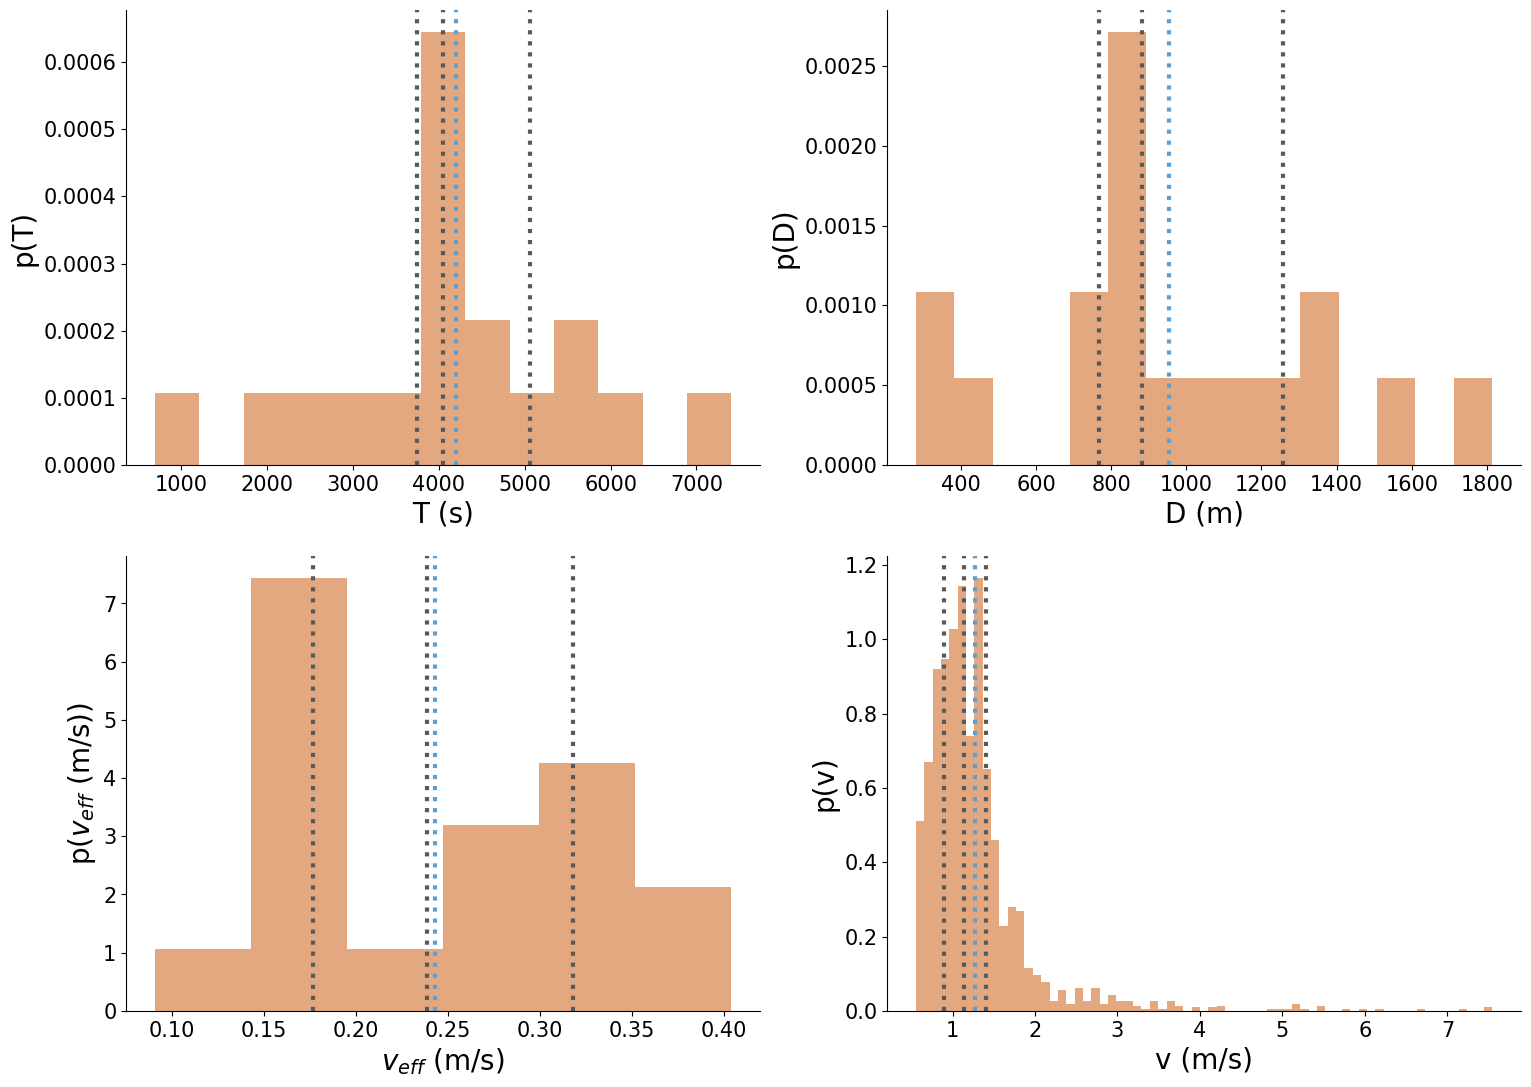

In [33]:
fig = plt.figure(figsize=(18, 13))
gs = fig.add_gridspec(nrows=2, ncols=2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

ax1.spines["top"].set_visible(False)    
ax1.spines["bottom"].set_visible(True)    
ax1.spines["right"].set_visible(False)    
ax1.spines["left"].set_visible(True)

ax2.spines["top"].set_visible(False)    
ax2.spines["bottom"].set_visible(True)    
ax2.spines["right"].set_visible(False)    
ax2.spines["left"].set_visible(True)

ax3.spines["top"].set_visible(False)    
ax3.spines["bottom"].set_visible(True)    
ax3.spines["right"].set_visible(False)    
ax3.spines["left"].set_visible(True)

ax4.spines["top"].set_visible(False)    
ax4.spines["bottom"].set_visible(True)    
ax4.spines["right"].set_visible(False)    
ax4.spines["left"].set_visible(True)

#ax1.text(1400, 0.0016, 'a', fontsize = 25)
#ax2.text(1400, 0.0016, 'b', fontsize = 25)
#ax3.text(2000, 0.0012, 'c', fontsize = 25)
#ax4.text(2000, 0.0012, 'd', fontsize = 25)


bins_t=int((max(durada_tots)-min(durada_tots))/500.)
ax1.hist(durada_tots, bins=bins_t,color='#C85200',alpha=0.5, density=True) 
ax1.axvline(x=q1_t, ymin=0, ymax=1, ls='dotted',linewidth=3, c='#595959')
ax1.axvline(x=q2_t, ymin=0, ymax=1, ls='dotted',linewidth=3, c='#595959')
ax1.axvline(x=q3_t, ymin=0, ymax=1, ls='dotted',linewidth=3, c='#595959')
ax1.axvline(x=mean_t, ymin=0, ymax=1, ls='dotted',linewidth=3, c='#5F9ED1')
ax1.set_xlabel('T (s)',fontsize=20)
ax1.set_ylabel('p(T)',fontsize=20)
ax1.tick_params(labelsize=15)


bins_d=int((max(distancia_tots)-min(distancia_tots))/100.)
ax2.hist(distancia_tots, bins=bins_d,color='#C85200',alpha=0.5, density=True) 
ax2.axvline(x=q1_d, ymin=0, ymax=1, ls='dotted',linewidth=3, c='#595959')
ax2.axvline(x=q2_d, ymin=0, ymax=1, ls='dotted',linewidth=3, c='#595959')
ax2.axvline(x=q3_d, ymin=0, ymax=1, ls='dotted',linewidth=3, c='#595959')
ax2.axvline(x=mean_d, ymin=0, ymax=1, ls='dotted',linewidth=3, c='#5F9ED1')
ax2.set_xlabel('D (m)',fontsize=20)
ax2.set_ylabel('p(D)',fontsize=20)
ax2.tick_params(labelsize=15)


bins_veff=int((max(vel_effectiva)-min(vel_effectiva))/0.05)
ax3.hist(vel_effectiva, bins=bins_veff,color='#C85200',alpha=0.5, density=True) 
ax3.axvline(x=q1_veff, ymin=0, ymax=1, ls='dotted',linewidth=3, c='#595959')
ax3.axvline(x=q2_veff, ymin=0, ymax=1, ls='dotted',linewidth=3, c='#595959')
ax3.axvline(x=q3_veff, ymin=0, ymax=1, ls='dotted',linewidth=3, c='#595959')
ax3.axvline(x=mean_veff, ymin=0, ymax=1, ls='dotted',linewidth=3, c='#5F9ED1')
ax3.set_xlabel(r'$v_{eff}$ (m/s)',fontsize=20)
ax3.set_ylabel(r'p($v_{eff}$ (m/s))',fontsize=20)
ax3.tick_params(labelsize=15)


bins_v=int((max(velocity_all)-min(velocity_all))/0.1)
ax4.hist(velocity_all, bins=bins_v,color='#C85200',alpha=0.5, density=True) 
ax4.axvline(x=q1_v, ymin=0, ymax=1, ls='dotted',linewidth=3, c='#595959')
ax4.axvline(x=q2_v, ymin=0, ymax=1, ls='dotted',linewidth=3, c='#595959')
ax4.axvline(x=q3_v, ymin=0, ymax=1, ls='dotted',linewidth=3, c='#595959')
ax4.axvline(x=mean_v, ymin=0, ymax=1, ls='dotted',linewidth=3, c='#5F9ED1')
ax4.set_xlabel('v (m/s)',fontsize=20)
ax4.set_ylabel('p(v)',fontsize=20)
ax4.tick_params(labelsize=15)


#plt.savefig('basic_statistics.pdf',format='pdf', bbox_inches='tight')

plt.show()


###  3.6 - Orientation (respect to the North) and reorientation (turning angle)

We compute the bearing angle from the North (given two GPS coordinate points) and the turning angle between consecutive orientations

--------------------------
FILE:  e1.csv
--------------------------


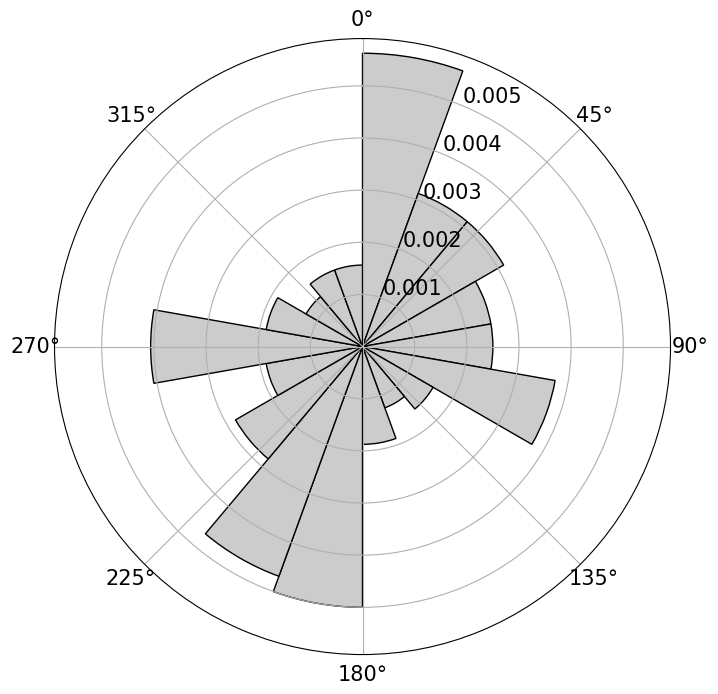

--------------------------
FILE:  e2.csv
--------------------------


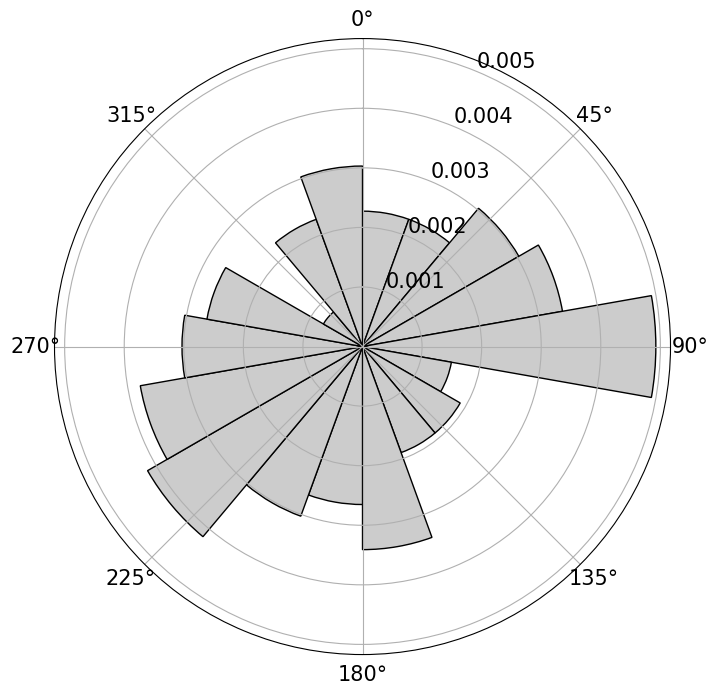

--------------------------
FILE:  e3.csv
--------------------------


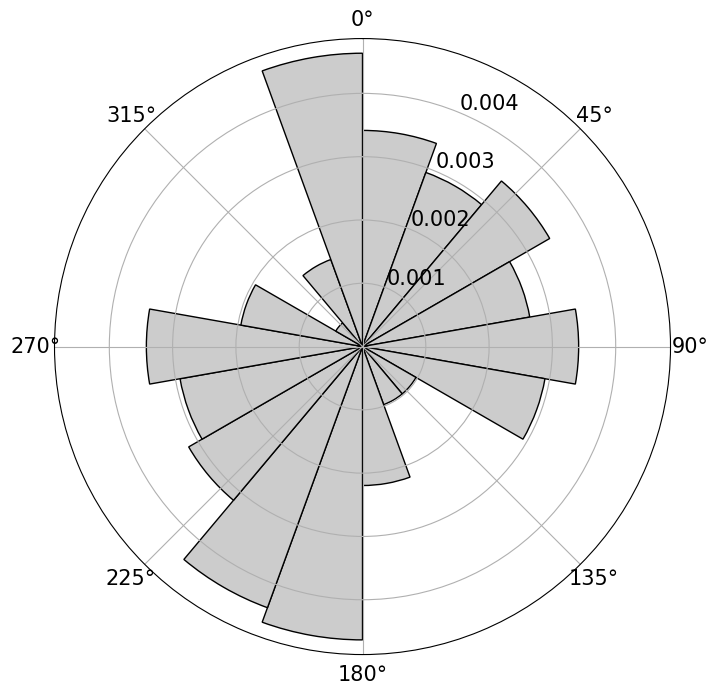

--------------------------
FILE:  e4.csv
--------------------------


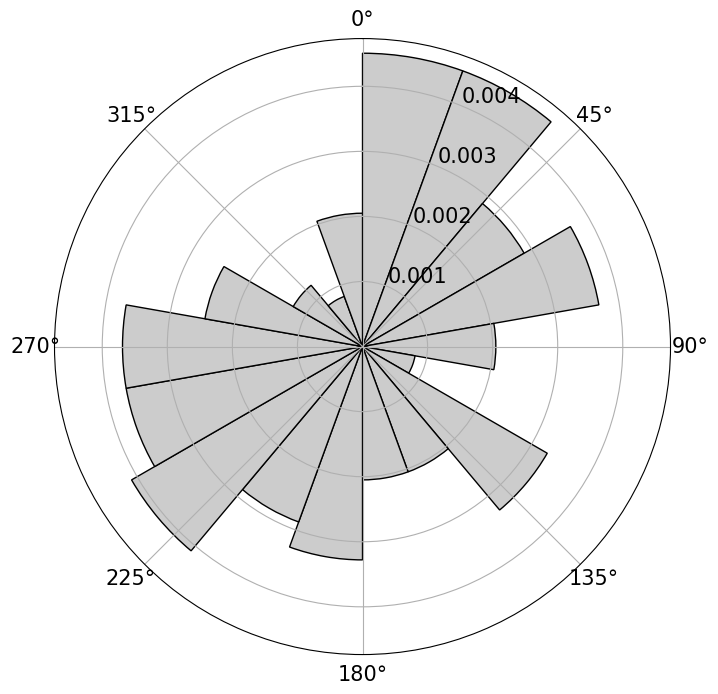

--------------------------
FILE:  e5.csv
--------------------------


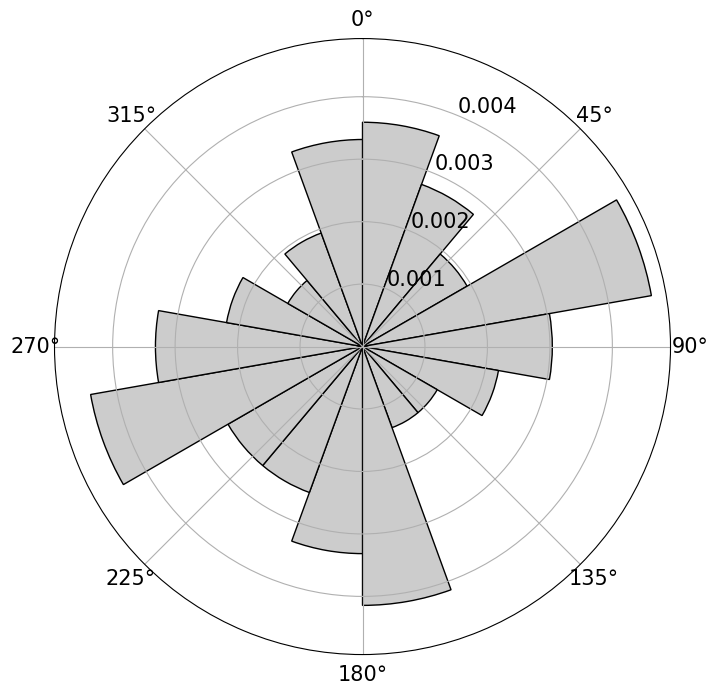

--------------------------
FILE:  e6.csv
--------------------------


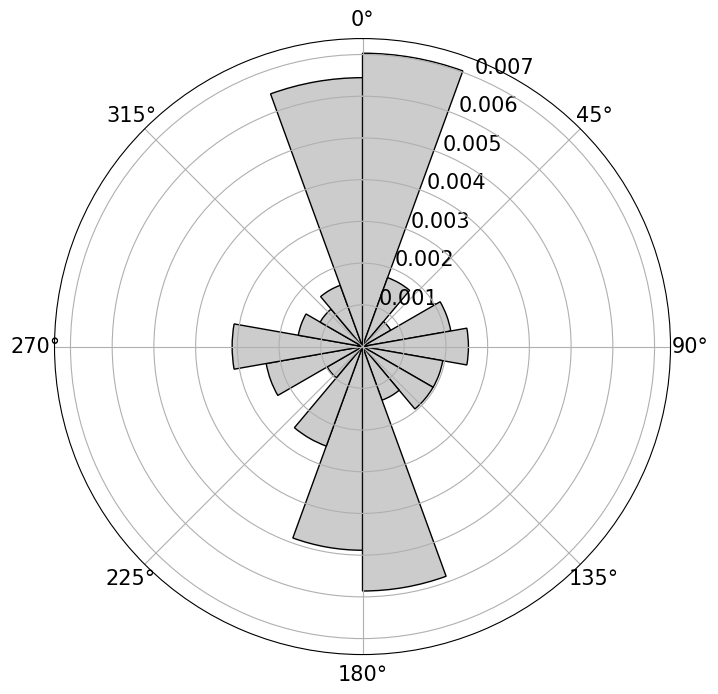

--------------------------
FILE:  e7.csv
--------------------------


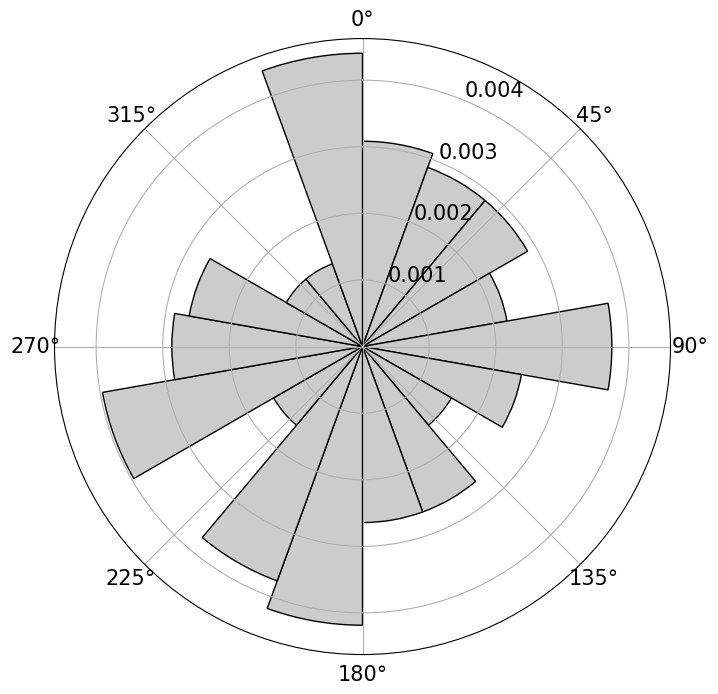

--------------------------
FILE:  g1.csv
--------------------------


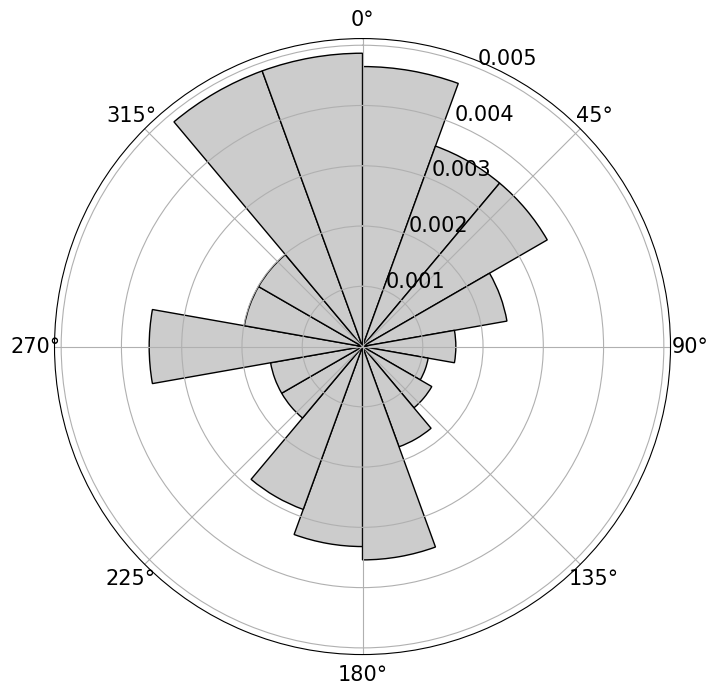

--------------------------
FILE:  g2.csv
--------------------------


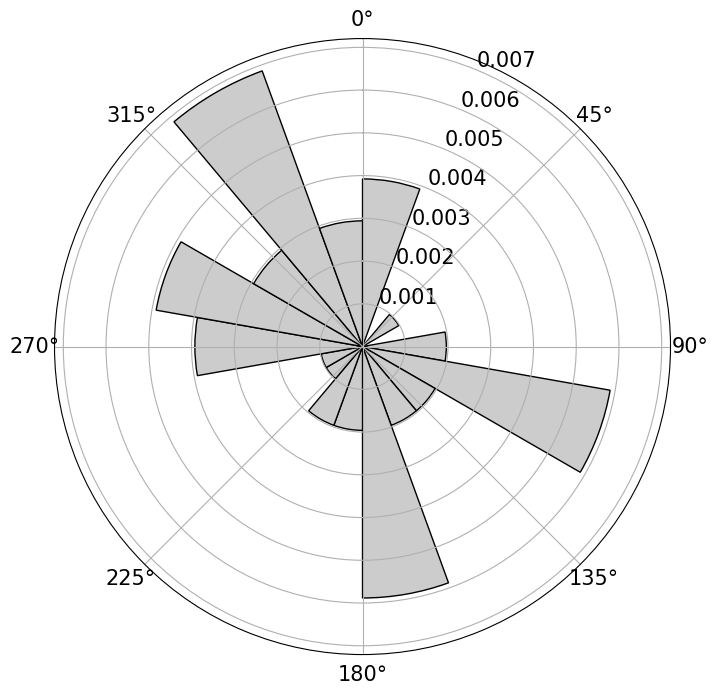

--------------------------
FILE:  g3.csv
--------------------------


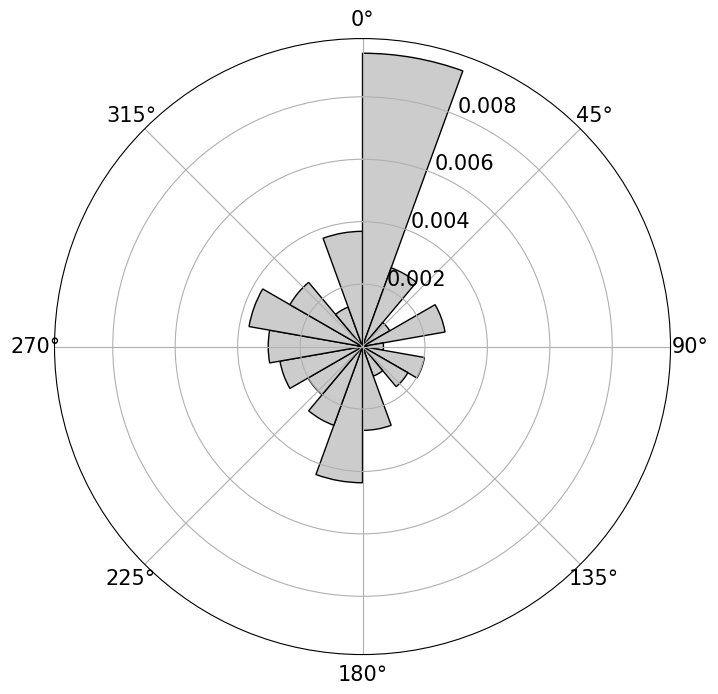

--------------------------
FILE:  g4.csv
--------------------------


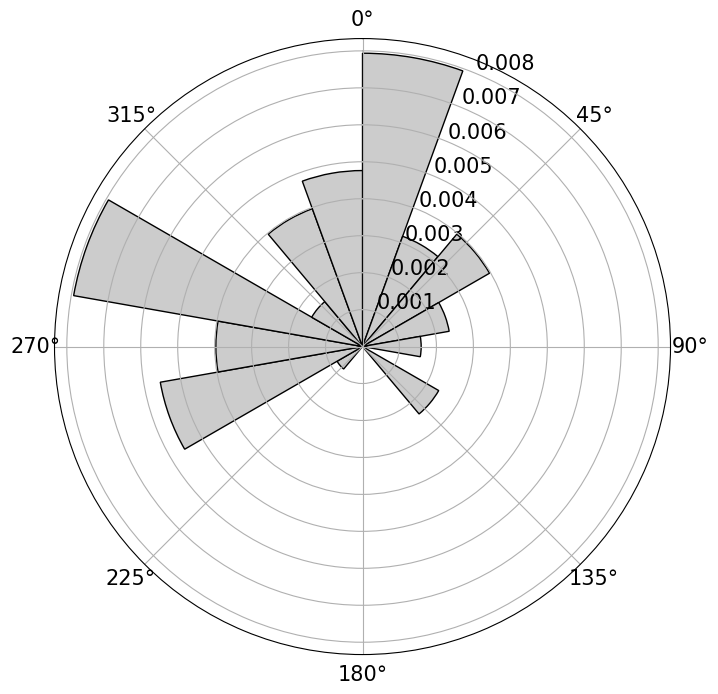

--------------------------
FILE:  g5.csv
--------------------------


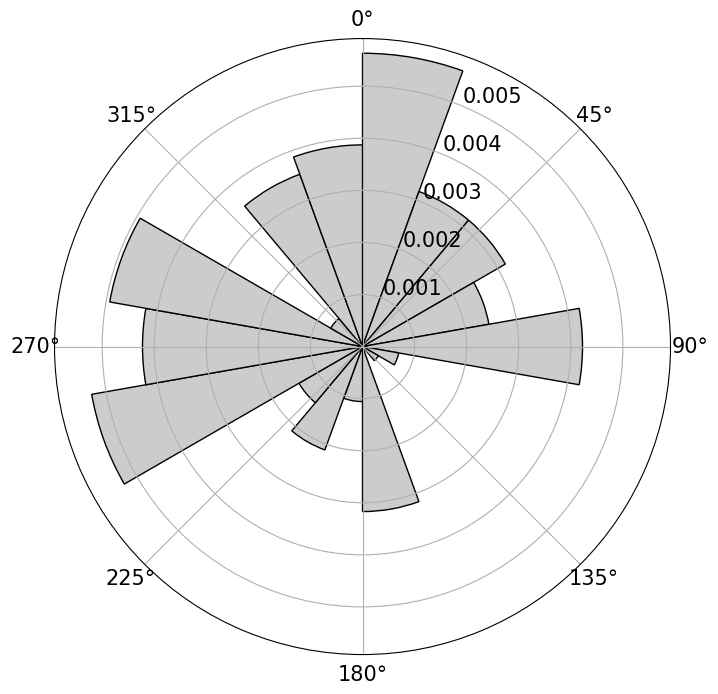

--------------------------
FILE:  g6.csv
--------------------------


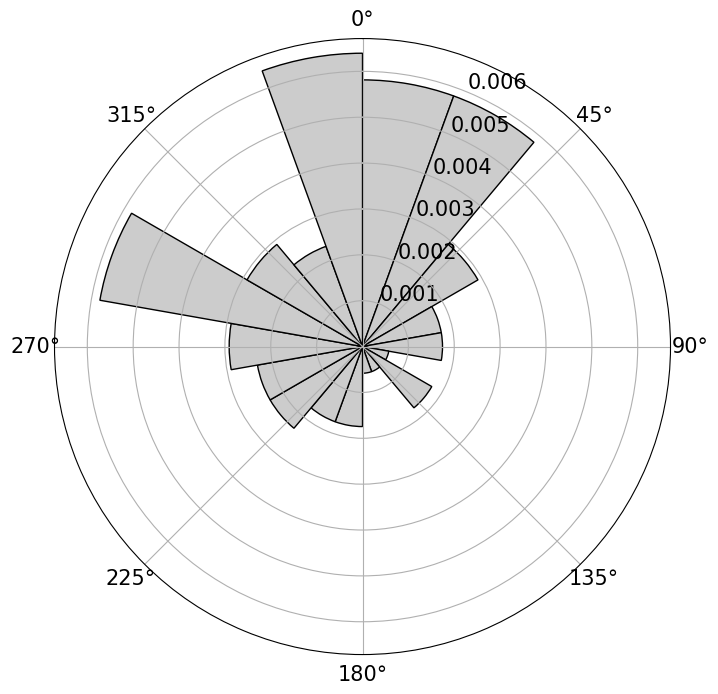

--------------------------
FILE:  g7.csv
--------------------------


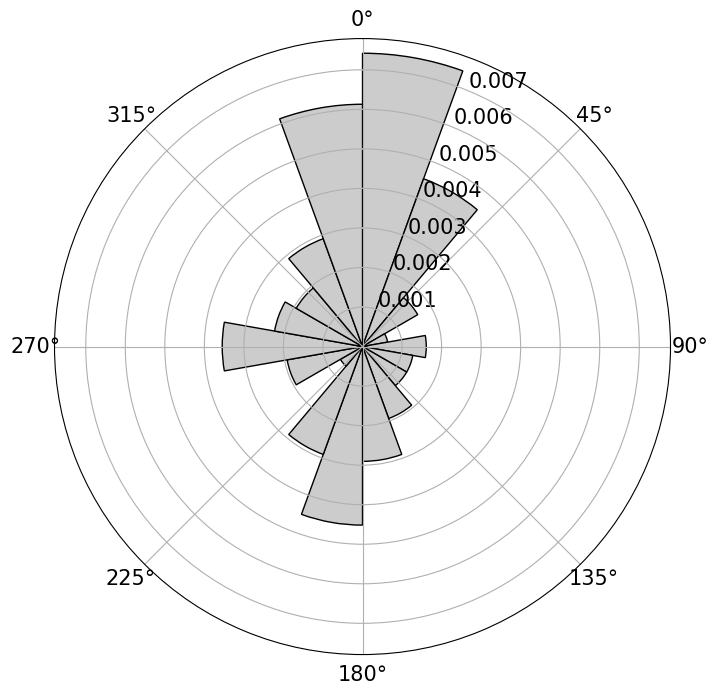

--------------------------
FILE:  g8.csv
--------------------------


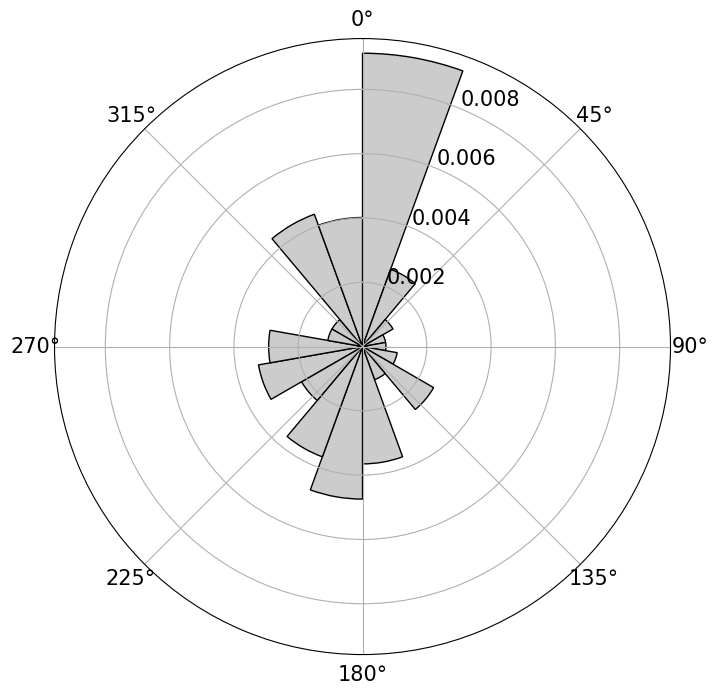

--------------------------
FILE:  p1.csv
--------------------------


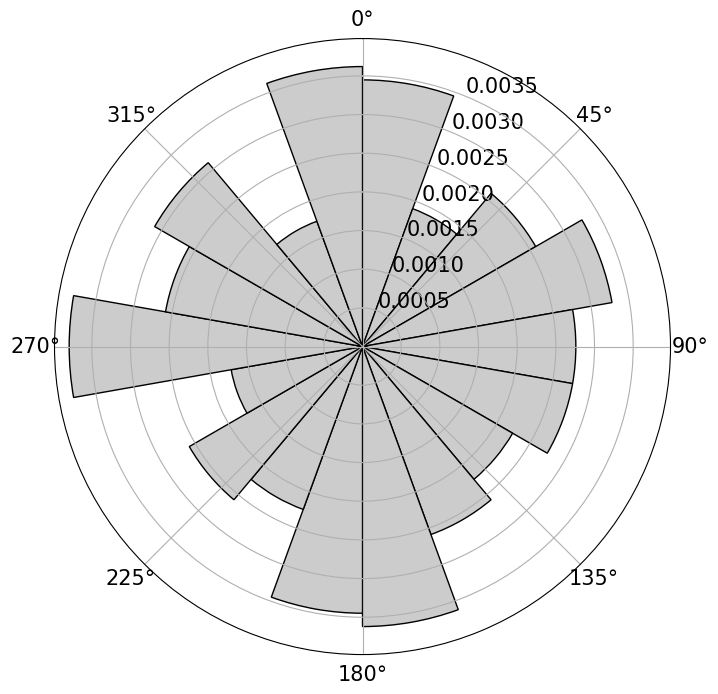

--------------------------
FILE:  p2.csv
--------------------------


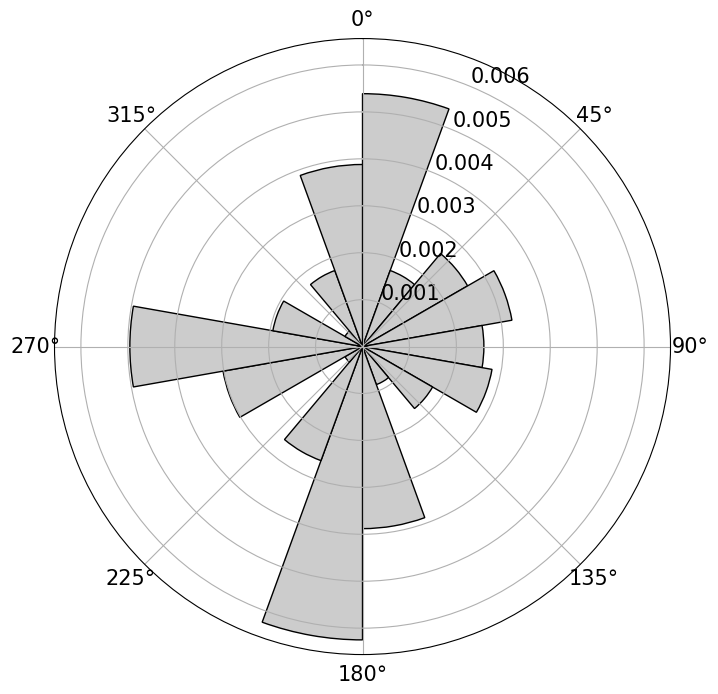

--------------------------
FILE:  p4.csv
--------------------------


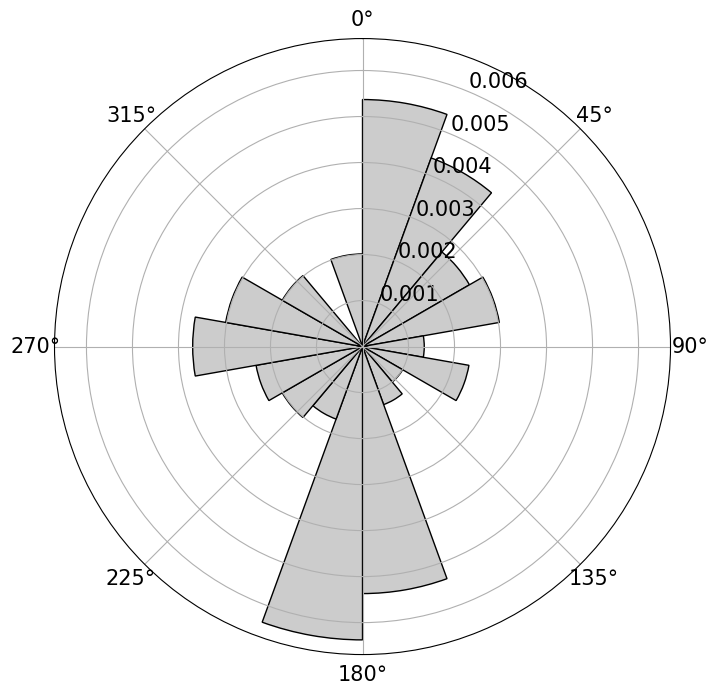

In [34]:
import math

def orientation(lat1, long1, lat2, long2):
    """ Given two GPS coordinate points (lat1,lon1) and (lat2,lon2), this function returns the bearing angle from the North.
        From 0 to 360º degrees clockwise.
        
    Inputs:
        - latitude and longitude of the 2 points
    
    Outputs:
        - Bearing (angle) in degrees from North (0 to 360º clockwise)
    """
    
    dLon = (long2 - long1)
    x = math.cos(math.radians(lat2)) * math.sin(math.radians(dLon))
    y = math.cos(math.radians(lat1)) * math.sin(math.radians(lat2)) - math.sin(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.cos(math.radians(dLon))
    brng = np.arctan2(x,y)
    brng = np.degrees(brng)
    
    # Make sure the bearing is positive
    bearing = (brng + 360) % 360
    
    return bearing


def reorientation(orientation1, orientation2):
    """ Given two orientations (of two consecutive vectors, i.e., 3 lat-lon points), this function returns the change in the
        orientation of the two vectors (the turning angle) in degrees.
        
        Given that the orientation is measured from the North (0-360º), if we want the reorientation to be in the range of 
        -180º to 180º (negative counter-clockwise and positive clockwise), then we need to conver those angles >180º and <-180º:
            
            · If reo < -180º then new_reo = 360-|reo|
            · If reo > 180º then new_reo = -(360-|reo|)

        Then we get an angle between 0º and -180º if the change in the orientation is counter-clockwise and between 0º and 180º 
        if clockwise.
        
    Inputs:
        - Two consecutive orientations from North (between 0 and 360º degrees). The orientation gives the bearing angle between
          the North and the movement vector between 2 points.
        
    Outputs:
        - Change in the orientation between 0º and -180º if counter-clockwise and between 0º and 180º if clockwise.
        
    """
    
    reo = orientation2 - orientation1  # reorientation
    
    if reo < -180:                  # Make sure that the range is (0º,180º) if clockwise) and (0,-180º) if counter-clockwise
        reo2 = 360 - abs(reo)
        return reo2
    
    if reo > 180:
        reo2 = -(360-abs(reo))
        return reo2
    
    else:
        return reo
    
    
def polar_histogram(x,width_bins):
    """ Function that creates a normalized polar histogram. It returns the counts (normalized frequences) and the positions of 
        the bins center.
        
        Inputs: 
            - variable x (list or array of angles, in degrees)
            - width of the bins
            
        Outputs:
            - Normalized counts (the normalization is such that the area below the curve is 1)
            - Bin centres (the position of the center of each bin)    
    """
    
    numpy_matrix = np.array(x)
    numpy_matrix_radians = np.deg2rad(x)
    
    bins = np.arange(0, 360+width_bins, width_bins)
    counts,bin_edges = np.histogram(numpy_matrix,bins=bins,density=True)   # frequences and bins
    bin_centres = np.deg2rad(np.ediff1d(bin_edges)//2 + bin_edges[:-1])
    
    return bin_centres, counts  


def histogram(x,width_bins):
    """ Function that creates a normalized histogram. It returns the counts (normalized frequences) and the positions of the 
        bins center.
        
        Inputs: 
            - variable x (list or array)
            - width of the bins
            
        Outputs:
            - Normalized counts (the normalization is such that the area below the curve is 1)
            - Bin centres (the position of the center of each bin)
    """
    
    numpy_matrix = np.array(x)
    bins=int((max(x)-min(x))/width_bins)
    counts,bin_edges = np.histogram(numpy_matrix,bins=bins,density=True)   # frequences and bins
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.   #bins center
    
    return bin_centres, counts


orient_all=[]
reo_all=[]

all_files = glob.glob(os.path.join("*.csv")) # Make list of paths (csv files for all individuals)
for file in all_files:   # Loop over all csv files in the folder/directory (each group/trajectory)
    
    df = pd.read_csv(file)  # Read the .csv
    df2 = df.copy()
    
    latitudes = df2['lat'].tolist()   # Latitudes and longitudes to lists
    longitudes = df2['lon'].tolist()

    orientations=[]
    for i in range(1,len(latitudes)):
        orientations.append(orientation(latitudes[i-1], longitudes[i-1], latitudes[i], longitudes[i]))

    orientations.insert(len(orientations), np.nan)  # Insert last element as NaN in order to add to the Data-Frame
    df2['orientation'] = orientations  # New column
    
    reorientations=[]
    for i in range(1,len(orientations)):
        reorientations.append(reorientation(orientations[i-1],orientations[i]))

    # Insert last element NaN in order to add to the Data-Frame
    reorientations.insert(len(reorientations), np.nan)  

    df2['reorientation'] = reorientations  # New column
    
    file2=file[:-4]

    df2.to_csv(file2+'.csv',index=False)
    
    print('--------------------------')    
    print('FILE: ', file )
    print('--------------------------')
    # Create the histogram using bins of 30 degrees width
    bin_width = 20
    bin_centres_orient, counts_orient = polar_histogram(orientations, 20)

    # Plot the polar histogram
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='polar')

    ax.bar(bin_centres_orient, counts_orient, width=np.deg2rad(bin_width), bottom=0.0, color='.8', edgecolor='k')

    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.tick_params(labelsize=15)

    plt.show()
    
    orient = df2['orientation'][:-1].tolist()
    orient_all.extend(orient)
    
    reo = df2['reorientation'][:-2].tolist()
    reo_all.extend(reo)

<θ> = 176º
q1(25%) = 76º,  q2(50%) = 184º,  q3(50%) = 269º


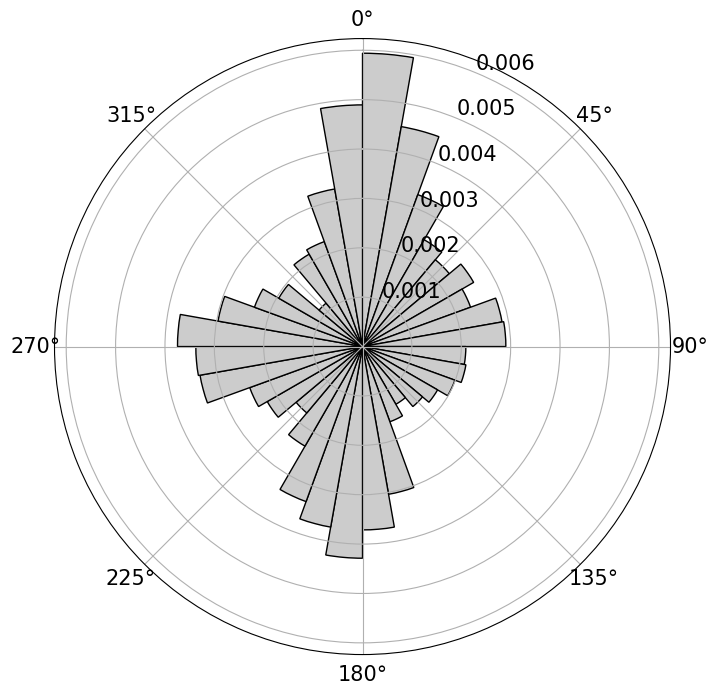

In [38]:
bin_width = 10
bin_centres_orient, counts_orient = polar_histogram(orient_all, 10)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='polar')

ax.bar(bin_centres_orient, counts_orient, width=np.deg2rad(bin_width), bottom=0.0, color='.8', edgecolor='k')

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.tick_params(labelsize=15)


print('<\u03B8> = {:.0f}º'.format(np.mean(orient_all)))
print('q1(25%) = {:.0f}º,  q2(50%) = {:.0f}º,  q3(50%) = {:.0f}º'.format(np.quantile(orient_all,0.25),np.quantile(orient_all,0.5),np.quantile(orient_all,0.75)))


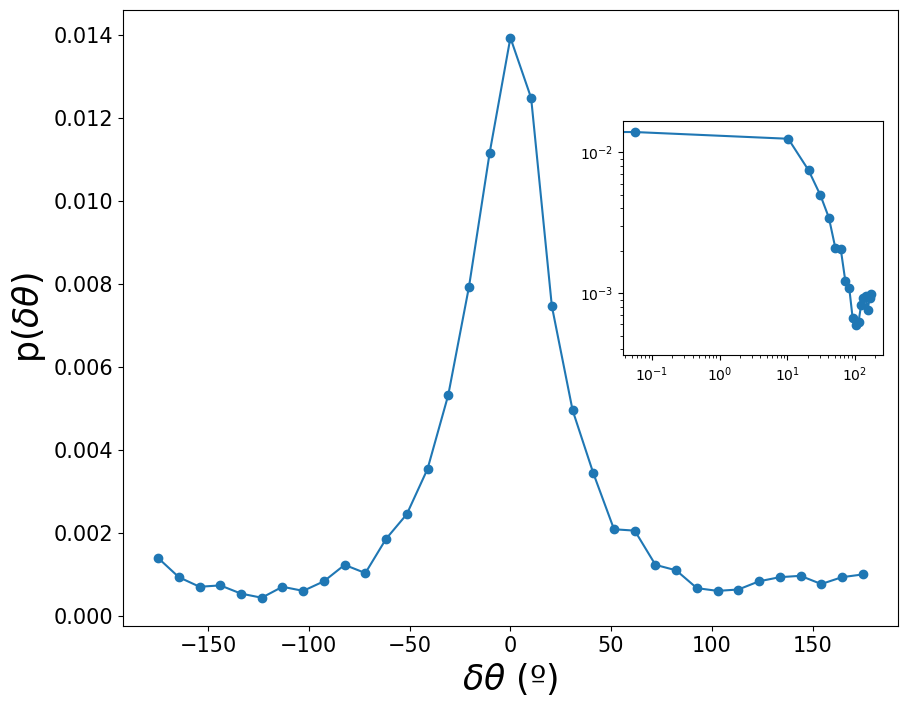

<δθ> = 0.44º
q1 = -22.24º,  q2 = 0.09º,  q3 = 22.14º


In [42]:
# Create the histogram using bins of 10 degrees width
bin_centres_reo, counts_reo = histogram(reo_all, 10)

# Plot the histogram
fig, ax = plt.subplots(figsize=(10,8)) 

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax, width="80%", height="100%", loc=1,bbox_to_anchor=(0.57,1-0.55,.42,.38), bbox_transform=ax.transAxes)

ax.plot(bin_centres_reo, counts_reo, 'o-', label='reo')    #plot pdf
axins.plot(bin_centres_reo, counts_reo, 'o-', label='reo')    #plot pdf

ax.set_xlabel(r'$\delta \theta$ (º)',fontsize=25)
ax.set_ylabel(r'p($\delta \theta$)',fontsize=25)
axins.set_yscale('log',base=10)
axins.set_xscale('log',base=10)
ax.tick_params(labelsize=15)

plt.show()


print('<\u03B4\u03B8> = {:.2f}º'.format(np.mean(reo_all)))
print('q1 = {:.2f}º,  q2 = {:.2f}º,  q3 = {:.2f}º'.format(np.quantile(reo_all,0.25),np.quantile(reo_all,0.5),np.quantile(reo_all,0.75)))